In [1]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense



sys.path.append("../Shared/")
from DataService import DataService

/tmp/ipykernel_2964940/2969248645.py:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-07-12 15:30:25.401984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-12 15:30:25.889605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sys.path.append("../Datasets/")
from DataCreation import getDatasetV1, getDatasetV2

# fetch data from db

In [3]:
df = getDatasetV2(None)
df.drop(columns=['year', 'district'], inplace=True)

# split data

In [4]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
oversampler = RandomOverSampler(random_state=42)
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=y)
# print(y_train.value_count())
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [5]:
y_train.value_counts()

True     667
False    667
Name: has_ergot, dtype: int64

In [6]:
X_train.columns

Index(['soil_moisture_mean', 'avg_percnt_coarse_frag', 'avg_total_sand',
       'avg_total_silt', 'avg_total_clay', 'avg_percnt_carbon',
       'avg_calcium_ph', 'avg_proj_ph', 'avg_water_reten_0',
       'avg_water_reten_10', 'avg_water_reten_33', 'avg_water_reten_1500',
       'avg_bulk_density', 'avg_elec_cond', 'avg_percnt_wood',
       'avg_water_holding_cap', 'avg_land_area', 'avg_water_area',
       'mean_total_precip', 'mean_temp', 'mean_snow_on_grnd',
       'mean_total_rain', 'mean_total_snow'],
      dtype='object')

In [7]:
# use StandardScaler when we don't know upper bounds
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
X_train_scaled.shape

(1334, 23)

In [9]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


2023-07-12 15:30:44.542147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:30:44.568434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-12 15:30:44.568717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# creating model

In [10]:
model = Sequential()

model.add(Dense(5, activation="relu", input_dim = X.shape[1]))
model.add(Dense(4, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
# model.add(Dense(1, activation="sigmoid", input_dim = X.shape[1]))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 120       
                                                                 
 dense_1 (Dense)             (None, 4)                 24        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 157
Trainable params: 157
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compile model
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=["accuracy"])

In [14]:
history = model.fit(X_train_scaled, y_train, epochs=1000, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/1000
34/34 [==============================] - 1s 5ms/step - loss: 0.6595 - accuracy: 0.6223 - val_loss: 0.8553 - val_accuracy: 0.0000e+00
Epoch 2/1000
 1/34 [..............................] - ETA: 0s - loss: 0.6880 - accuracy: 0.5000

2023-07-12 15:31:04.001040: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6110008f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-12 15:31:04.001066: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-07-12 15:31:04.006389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-12 15:31:04.006422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-12 15:31:04.027128: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.6251 - val_loss: 0.8617 - val_accuracy: 0.0000e+00
Epoch 3/1000
34/34 [==============================] - 0s 1ms/step - loss: 0.6401 - accuracy: 0.6251 - val_loss: 0.8894 - val_accuracy: 0.0000e+00
Epoch 4/1000
34/34 [==============================] - 0s 1ms/step - loss: 0.6332 - accuracy: 0.6251 - val_loss: 0.9062 - val_accuracy: 0.0000e+00
Epoch 5/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.6269 - accuracy: 0.6251 - val_loss: 0.9111 - val_accuracy: 0.0000e+00
Epoch 6/1000
34/34 [==============================] - 0s 1ms/step - loss: 0.6201 - accuracy: 0.6251 - val_loss: 0.9112 - val_accuracy: 0.0000e+00
Epoch 7/1000
34/34 [==============================] - 0s 1ms/step - loss: 0.6130 - accuracy: 0.6251 - val_loss: 0.9270 - val_accuracy: 0.0000e+00
Epoch 8/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.6070 - accuracy: 0.6251 - val_loss: 0.9257 - val_accuracy: 0.

# predictions

In [15]:
y_pred = model.predict(X_test_scaled)

7/7 [==============================] - 0s 619us/step


In [16]:
threshhold = 0.8
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [17]:
accuracy_score(y_test, y_pred)

0.7087378640776699

# plotting

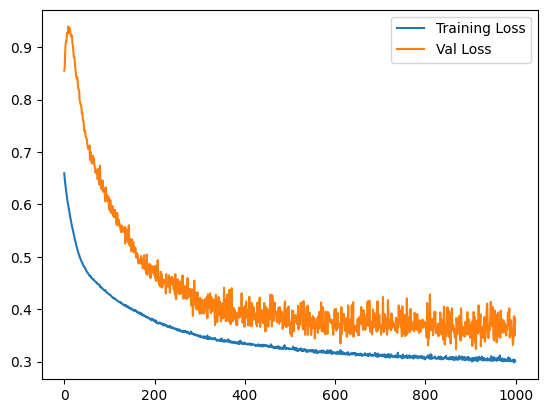

In [18]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

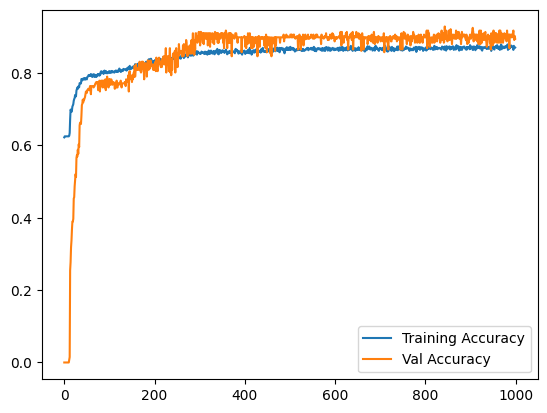

In [19]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

# report

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.35      0.68      0.46        38
        True       0.91      0.71      0.80       168

    accuracy                           0.71       206
   macro avg       0.63      0.70      0.63       206
weighted avg       0.81      0.71      0.74       206



0.6992481203007519


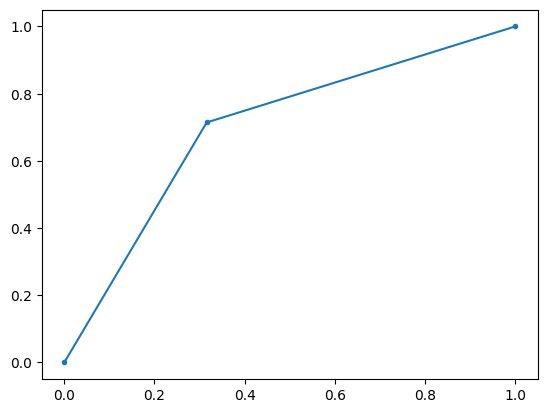

In [21]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".")
print(auc_)

In [22]:
# prints weight with attribute
attributes = X_train.columns.tolist()
weights = model.layers[0].get_weights()[0]
bias = model.layers[0].get_weights()[1]

result = {}

for x, y in zip(attributes, weights):
    result[x] = y

result = pd.DataFrame(result)

result.transpose()
print(result.max())

soil_moisture_mean        0.536234
avg_percnt_coarse_frag    0.985640
avg_total_sand            0.508649
avg_total_silt            0.502167
avg_total_clay            0.238672
avg_percnt_carbon         0.780523
avg_calcium_ph           -0.107161
avg_proj_ph               0.533724
avg_water_reten_0         0.432919
avg_water_reten_10        0.312127
avg_water_reten_33        0.731525
avg_water_reten_1500      1.010168
avg_bulk_density          0.395807
avg_elec_cond             0.524621
avg_percnt_wood           0.609570
avg_water_holding_cap     0.479249
avg_land_area             0.218577
avg_water_area            0.919146
mean_total_precip         0.388490
mean_temp                 0.193700
mean_snow_on_grnd         0.673982
mean_total_rain           0.034440
mean_total_snow           0.276244
dtype: float32
